In [1]:
# To be run after Adult-Data-Prep-1
%matplotlib inline
# Load all necessary packages
import sys
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# Import IBM's AI Fairness tooolbox
from aif360.datasets import BinaryLabelDataset
from aif360.metrics  import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
# Import scikit-learn core slibraries
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics       import accuracy_score
from common_utils          import compute_metrics
from IPython.display       import Markdown, display
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned Adult dataset
Adult_df = pd.read_csv('./input/adult-cleaned.csv')

In [3]:
# The AIF demo drops the following columns - we'll try the same
Adult_df.drop(["Fnlwgt", "NativeCountry", "Relationship", "MaritalStatus"],axis=1,inplace=True)

In [4]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'Gender'
priv_grp            = 1  # Males 
unpriv_grp          = 0  # Females  
lab                 = 'Income'
fav_label           = 1 # Income over £50K
unfav_label         = 0 # Income under £50K
privileged_groups   = [{protected_attr: priv_grp}]   # Males
unprivileged_groups = [{protected_attr: unpriv_grp}] # Females

In [5]:
X = Adult_df.drop(lab,axis=1)
y = Adult_df[lab]

In [6]:
# Create a Binary Label Dataset to use with AIF360 APIs
Adult_bld = BinaryLabelDataset(df=pd.concat((X, y), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)

In [7]:
Adult_train, Adult_vt   = Adult_bld.split([0.8], shuffle=True)
Adult_valid, Adult_test = Adult_vt.split([0.5], shuffle=True)

In [8]:
# Metric for the original dataset
metric_train_bld = BinaryLabelDatasetMetric(Adult_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print('Base Rate                     :', metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

#### Biased training dataset

Number of instances           : 39073.0
Base Rate                     : 0.23957720164819696
Consistency                   : [0.83244696]
Disparate Impact              : 0.3694063290301542
Mean Difference               : -0.1911607961153221
Statistical Parity Difference : -0.1911607961153221
# of positives(privileged)    : 7906.0
# of positives(non-privileged): 1455.0
Total positive instances"     : 9361.0
# of negatives(privileged)    : 18174.0
# of negatives(non-privileged): 11538.0
Total negative instances"     : 29712.0
Difference in mean outcomes between unprivileged and privileged groups = -0.191161


In [9]:
#Train with and transform the original training data
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(Adult_train)
Adult_train_lfr = RW.transform(Adult_train)

In [10]:
### Testing 
assert np.abs(Adult_train_lfr.instance_weights.sum()-Adult_train.instance_weights.sum())<1e-6

In [11]:
#Metric with the transformed training data
metric_train_lfr = BinaryLabelDatasetMetric(Adult_train_lfr, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Debiased training dataset"))
print('Number of instances           :', metric_train_lfr.num_instances())
print('Base Rate                     :', metric_train_lfr.base_rate())
print('Consistency                   :', metric_train_lfr.consistency())
print('Disparate Impact              :', metric_train_lfr.disparate_impact())
print('Mean Difference               :', metric_train_lfr.mean_difference())
print('Statistical Parity Difference :', metric_train_lfr.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_lfr.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_lfr.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_lfr.num_positives(privileged=True)+metric_train_lfr.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_lfr.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_lfr.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_lfr.num_negatives(privileged=True)+metric_train_lfr.num_negatives(privileged=False))

print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_lfr.mean_difference())

#### Debiased training dataset

Number of instances           : 39073.0
Base Rate                     : 0.23957720164819696
Consistency                   : [0.83244696]
Disparate Impact              : 1.0000000000000007
Mean Difference               : 1.3877787807814457e-16
Statistical Parity Difference : 1.3877787807814457e-16
# of positives(privileged)    : 6248.173418984976
# of positives(non-privileged): 3112.826581015024
Total positive instances"     : 9361.0
# of negatives(privileged)    : 19831.826581015033
# of negatives(non-privileged): 9880.173418984978
Total negative instances"     : 29712.00000000001
Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [12]:
### Testing 
assert np.abs(metric_train_lfr.mean_difference()) < 1e-6

In [13]:
###Train logistic regression classifier on biased training data

In [14]:
# Logistic regression classifier and predictions
scale_orig = MinMaxScaler()
#scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(Adult_train.features)
y_train = Adult_train.labels.ravel()
w_train = Adult_train.instance_weights.ravel() # All of these will 1's.

lmod = LogisticRegression()
lmod.fit(X_train, y_train, sample_weight=Adult_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# determine the protected attribute class index value?
pos_ind = np.where(lmod.classes_ == Adult_train.favorable_label)[0][0]

Adult_train_pred        = Adult_train.copy()
Adult_train_pred.labels = y_train_pred

In [15]:
#Use the trained model to obtain scores for original validation and test sets
Adult_valid_pred = Adult_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(Adult_valid_pred.features)
y_valid = Adult_valid_pred.labels
Adult_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

Adult_test_pred = Adult_test.copy(deepcopy=True)
X_test = scale_orig.transform(Adult_test_pred.features)
y_test = Adult_test_pred.labels
Adult_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [16]:
###Determine Best Classification threshold & Best Balancced Accuracy for biased validation data

In [17]:
#Find the biased optimal classification threshold from the validation set

num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = Adult_valid_pred.scores > class_thresh
    Adult_valid_pred.labels[fav_inds] = Adult_valid_pred.favorable_label
    Adult_valid_pred.labels[~fav_inds] = Adult_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(Adult_valid,Adult_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Validation data - Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Validation data - Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Validation data - Best balanced accuracy (no reweighing) = 0.7588
Validation data - Optimal classification threshold (no reweighing) = 0.2080


In [18]:
###Use best classification threshold on the biased test data

In [19]:
#Predictions from the original test set at the optimal classification threshold
display(Markdown("#### Predictions from original testing data using best classification threshold"))
bal_acc_arr_orig       = []
disp_imp_arr_orig      = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = Adult_test_pred.scores > thresh
    Adult_test_pred.labels[fav_inds] = Adult_test_pred.favorable_label
    Adult_test_pred.labels[~fav_inds]= Adult_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(Adult_test, Adult_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data using best classification threshold

Classification threshold used = 0.2080


 17%|████████████████████▌                                                                                                    | 17/100 [00:00<00:01, 42.75it/s]

Balanced accuracy = 0.7582
Statistical parity difference = -0.3896
Disparate impact = 0.2774
Average odds difference = -0.2966
Equal opportunity difference = -0.2992
Theil index = 0.0992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 50.73it/s]


Display Disparate Impact v/s Balanced Accuracy for all thresholds


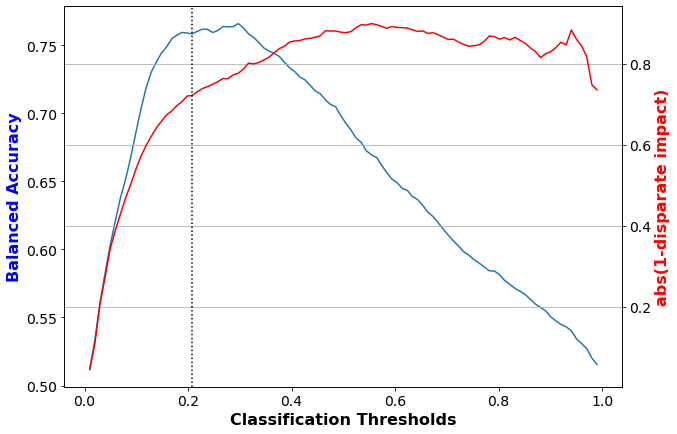

In [20]:
print('Display Disparate Impact v/s Balanced Accuracy for all thresholds')
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [21]:
print('abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.')
print('However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.')

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.
However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.


Display Average Odds Difference v/s Balanced Accuracy for all thresholds


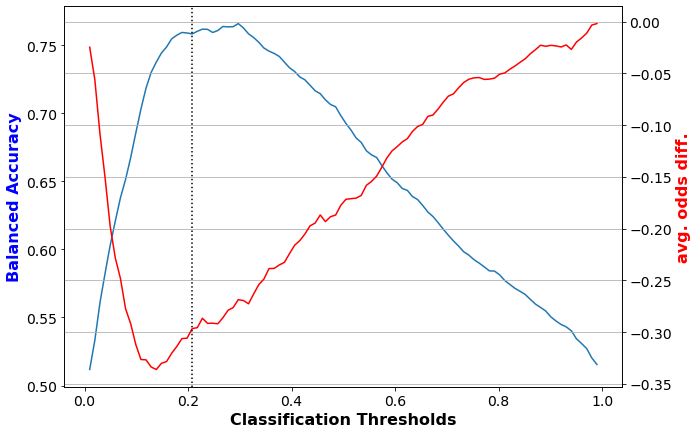

In [22]:
print('Display Average Odds Difference v/s Balanced Accuracy for all thresholds')
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [23]:
print('average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.')
print('However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.')

average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.
However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.


In [24]:
###Now run a logistic regression on debiased Train data

In [25]:
scale_transf = MinMaxScaler()
X_train = scale_transf.fit_transform(Adult_train_lfr.features)
y_train = Adult_train_lfr.labels.ravel()

lmod = LogisticRegression()
# lmod will be the debiased logistic model
lmod.fit(X_train, y_train,
        sample_weight=Adult_train_lfr.instance_weights) # These will be the modified weights
y_train_pred = lmod.predict(X_train)

In [26]:
#Obtain scores for transformed test set using the debiased lmod
Adult_test_lfr_pred = Adult_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(Adult_test_lfr_pred.features)
y_test = Adult_test_lfr_pred.labels
# lmod is the logistic regression model trained on the debiased data
Adult_test_lfr_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [27]:
###Predictions from the transformed test set at the optimal classification threshold

In [28]:
display(Markdown("#### Predictions from transformed testing data"))
balanced_acc_lfr = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = Adult_test_lfr_pred.scores > thresh
    Adult_test_lfr_pred.labels[fav_inds] = Adult_test_lfr_pred.favorable_label
    Adult_test_lfr_pred.labels[~fav_inds] = Adult_test_lfr_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(Adult_test, Adult_test_lfr_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    balanced_acc_lfr.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.2080


 20%|████████████████████████▏                                                                                                | 20/100 [00:00<00:01, 41.01it/s]

Balanced accuracy = 0.7293
Statistical parity difference = -0.0632
Disparate impact = 0.8576
Average odds difference = 0.0163
Equal opportunity difference = -0.0126
Theil index = 0.1098


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


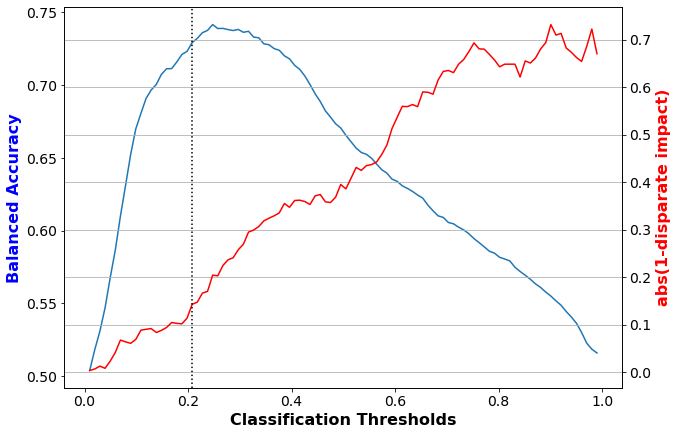

In [29]:
#Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, balanced_acc_lfr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [30]:
print('abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.')
print('For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.')

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.
For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.


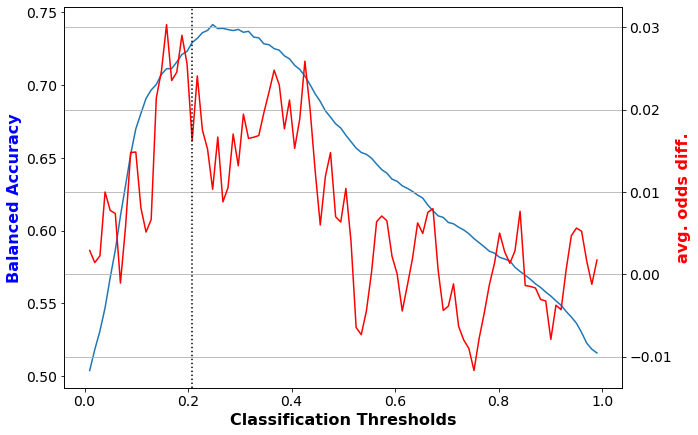

In [31]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, balanced_acc_lfr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [32]:
print('average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.')
print('For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness')

average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.
For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness
